# Decision Trees and Random Forests

![](https://i.imgur.com/N8aIuRK.jpg)

The following topics are covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting & hyperparameter tuning
- Making predictions on single inputs


In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import jovian
import os

In [2]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)
data_dir='./weather-dataset-rattle-package'
train_csv = data_dir + '/weatherAUS.csv'
raw_df = pd.read_csv(train_csv)

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [3]:
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] =  '#00000000'
                    

In [5]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/4095005054.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year, palette='husl')


<AxesSubplot:title={'center':'No of rows per year'}, xlabel='Date', ylabel='count'>

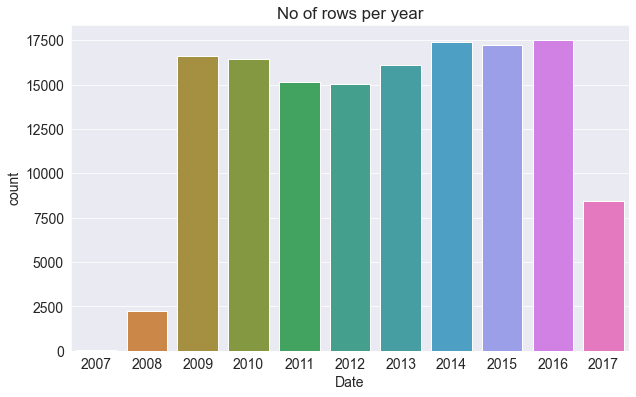

In [7]:
plt.title('No of rows per year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year, palette='husl')

In [8]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [9]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)


train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


In [10]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [11]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [12]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [13]:
#identifying the numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [14]:
print(numeric_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [15]:
print(categorical_cols)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

### Imputing missing numeric values

In [18]:
from sklearn.impute import SimpleImputer

In [20]:
train_inputs[numeric_cols].isna().sum().sort_values(ascending=False)

Sunshine         40696
Evaporation      37110
Cloud3pm         36766
Cloud9am         35764
Pressure9am       9345
Pressure3pm       9309
WindGustSpeed     6902
Humidity9am       1265
Humidity3pm       1186
WindSpeed3pm      1140
WindSpeed9am      1133
Rainfall          1000
Temp9am            783
Temp3pm            663
MinTemp            434
MaxTemp            198
dtype: int64

In [19]:
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

In [21]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [22]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Scaling Numeric Features

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [25]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [27]:
train_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.013233,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0304,0.0,0.0,0.027426,0.005758
max,1.0,1.000000,1.0,0.568276,0.986207,1.0,0.669231,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.000000,0.988484


### Encoding Categorical Data

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
train_df[categorical_cols] = train_df[categorical_cols].fillna('Unknown', inplace =True)
val_df[categorical_cols] = val_df[categorical_cols].fillna('Unknown', inplace =True)
test_df[categorical_cols] = test_df[categorical_cols].fillna('Unknown', inplace =True)

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/410610519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[categorical_cols] = train_df[categorical_cols].fillna('Unknown', inplace =True)
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/410610519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[categorical_cols] = train_df[categorical_cols].fillna('Unknown', inplace =True)
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/410610519.py:2: SettingWithCopyWarning: 
A value is trying to be set on 

## NOTE: To check version of a library use !pip list 

In [34]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [37]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [38]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/1584174743.py:1: PerformanceWarning: DataFrame is highl

In [39]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
2498,Albury,0.681604,0.801512,0.000000,0.037723,0.525852,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.5136,0.777778,0.333333,0.702532,0.808061,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037723,0.525852,SSE,0.341085,SSE,SE,0.069231,0.195402,0.54,0.30,0.505785,0.5008,0.888889,0.888889,0.675105,0.712092,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037723,0.525852,ENE,0.325581,ESE,ENE,0.084615,0.448276,0.62,0.67,0.553719,0.6032,0.888889,0.888889,0.611814,0.477927,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2501,Albury,0.608491,0.538752,0.042049,0.037723,0.525852,SSE,0.255814,SE,SSE,0.069231,0.195402,0.74,0.65,0.618182,0.6304,0.888889,0.888889,0.556962,0.518234,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [40]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [41]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

For eg. in this case, we let the computer decide the important parameter. Lets say it started with 'RainToday' as one of the parameter, then based on Yes or No answer, it can look for other parameter like 'WindSpeed' and others  

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
model = DecisionTreeClassifier(random_state = 42) # some randomness involved in how DT works, to get the same \
# output use the same seed

In [45]:
%%time 
model.fit(X_train, train_targets)


CPU times: user 2.04 s, sys: 23.2 ms, total: 2.07 s
Wall time: 2.08 s


DecisionTreeClassifier(random_state=42)

In [46]:
train_preds = model.predict(X_train)

In [47]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [48]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 98988, dtype: object

In [49]:
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

In [50]:
pd.value_counts(train_targets)

No     76705
Yes    22283
Name: RainTomorrow, dtype: int64

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [53]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

In [54]:
train_probs = model.predict_proba(X_train)

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [55]:
model.score(X_val, val_targets)

0.7921188555510418

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [56]:
model.score(X_test, test_targets)

0.7741202741202741

In [57]:
val_targets.value_counts()/len(val_targets)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [58]:
from sklearn.tree import plot_tree, export_text
# plot_tree uses matplotlib under the hood

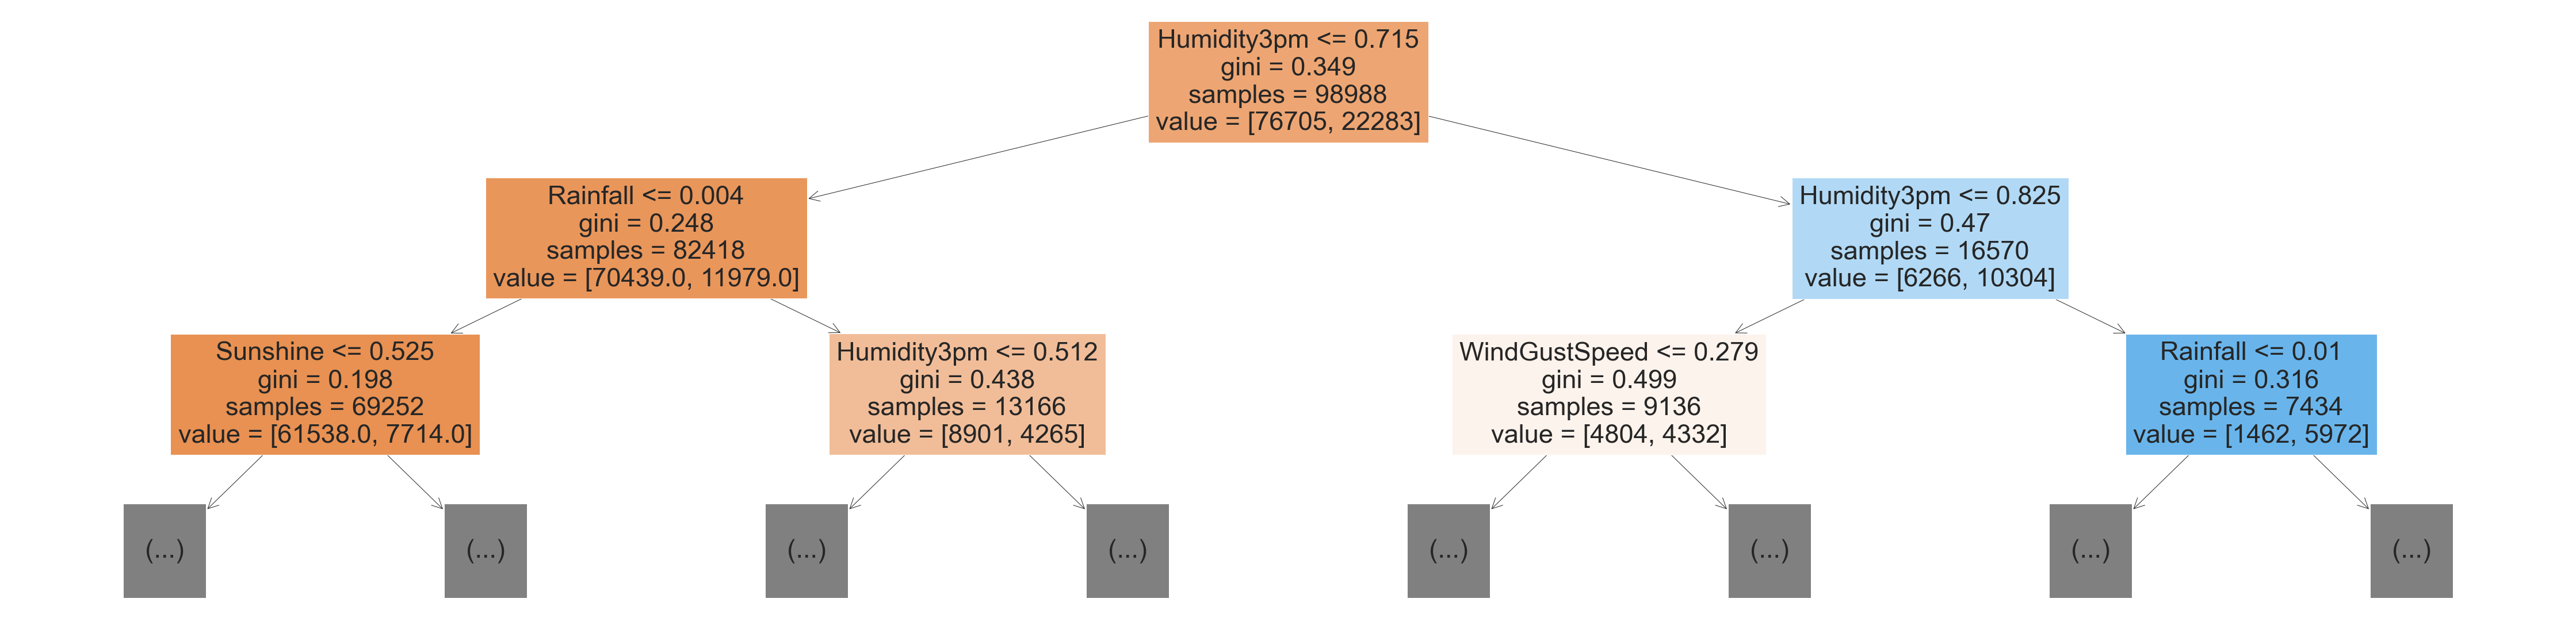

In [62]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


Decision Tree:
- Hierarchical structure based on feature splits.
- Handles non-linear relationships well.
- Offers intuitive interpretation.
- Robust to outliers.
- Can be computationally expensive for large datasets.

- Decision trees offer intuitive interpretations, as each split corresponds to a decision based on a single feature. It's easy to understand the decision-making process.

Logistic Regression:
- Linear model predicting probabilities.
- Assumes linear relationship between features and outcome.
- Less interpretable compared to decision trees.
- Sensitive to outliers.
- More computationally efficient, suitable for large datasets.

- While logistic regression can provide coefficients indicating the impact of each feature on the outcome, the interpretation might not be as straightforward as decision trees, especially when dealing with interactions between features.

**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://i.imgur.com/tlYiXnp.png" width="480">


Let's check the depth of the tree that was created.

In [63]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

In [64]:
model.tree_.max_depth

48

In [70]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

> **EXERCISE**: Based on the above discussion, can you explain why the training accuracy is 100% whereas the validation accuracy is lower?

B/c the model has learned every training set and when it sees an example that it has not seen before, it tries to categories it into one of the existing training example by following one path of the DT, which may or may not work for that particular case. THIS IS CALLED **OVERFITTING** where model has learned specific training example and does not generalize well to the example it has not seen before

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [73]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan', 'RainToday_No',
       'RainToday_Yes', 'RainToday_nan'],
      dtype='object', length=119)

In [72]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [77]:
importance_df = pd.DataFrame({
    'feature' : X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending = False)

In [79]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/3768822133.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(importance_df.head(10), y='feature', x='importance', palette='husl')


<AxesSubplot:xlabel='importance', ylabel='feature'>

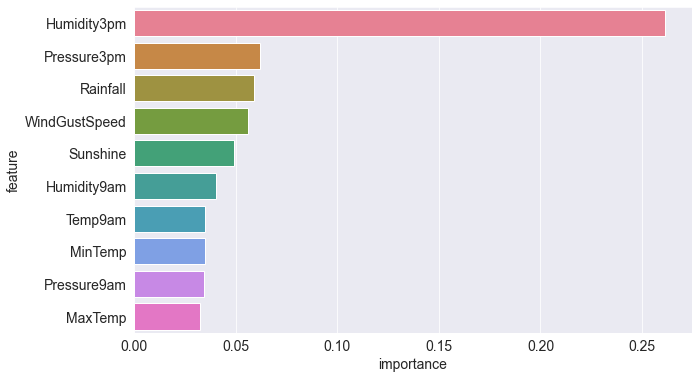

In [83]:
sns.barplot(importance_df.head(10), y='feature', x='importance', palette='husl')

In [84]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. 


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [85]:
? DecisionTreeClassifier

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

Anything a model learns or figures out on its own is called a parameter and hyperparameter is something that we provide to the ML algorithm to make the accuracy better 

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [86]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [87]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [88]:
model.score(X_train, train_targets)

0.8291308037337859

In [89]:
model.score(X_val, val_targets)

0.8334397307178921

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.
It might seem counter-intuitive at first, that the 3 level deep tree is more accurate than a 48-level tree. But it makes sense because a 3 level tree is picking up the general trend whereas 48 level tree is learning specific training examples. And in ML, we want the model to learn the general trend

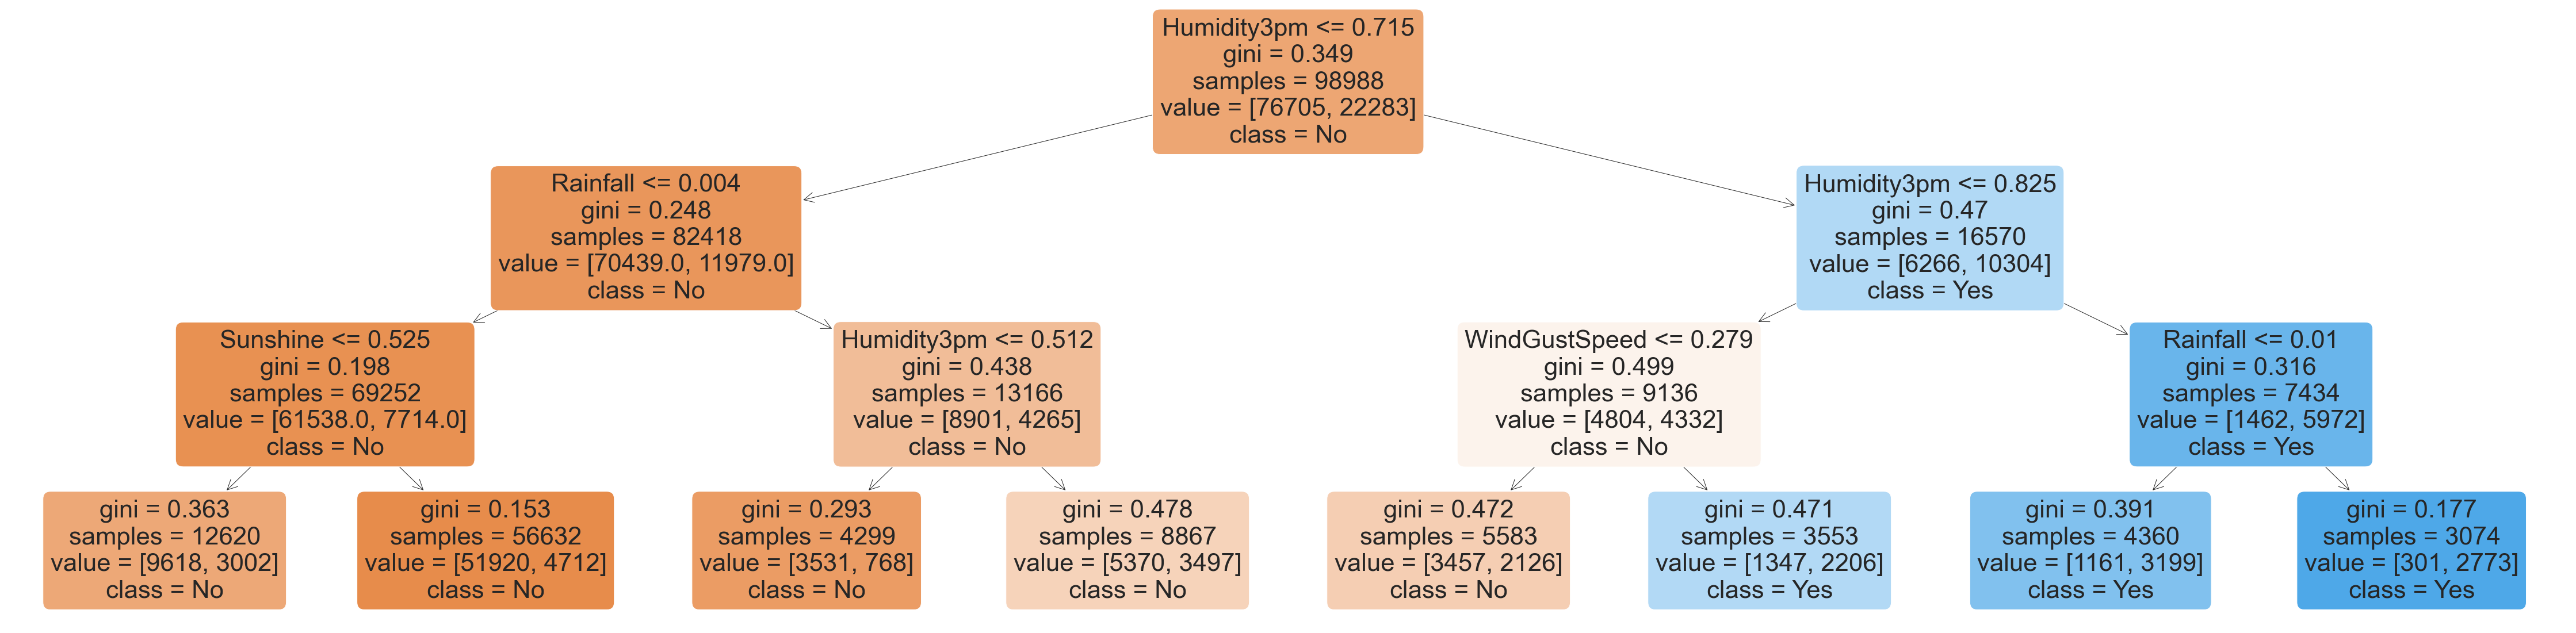

In [98]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns,filled=True,  rounded=True, class_names=model.classes_);

Let's experiment with different depths using a helper function.

Max depth lies somewhere b/w 3 and 40. 

In [99]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md,random_state=42)
    model.fit(X_train,train_targets)
    train_err = 1 - model.score(X_train, train_targets)
    val_err = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Err': train_err, 'Validation Err': val_err}

In [100]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])

CPU times: user 24.2 s, sys: 274 ms, total: 24.5 s
Wall time: 24.6 s


In [101]:
errors_df

,Max Depth,Training Err,Validation Err
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


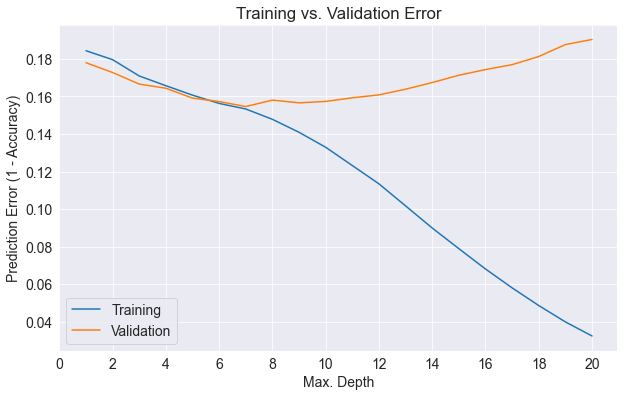

In [104]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Err'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Err'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


Model complexity--> size of your model, overall parameters of your model. 


You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [106]:
model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(X_train, train_targets)
model.score(X_train, train_targets)

0.8466884874934335

In [107]:
model.score(X_val, val_targets)

0.8453949277465034

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [108]:
model=DecisionTreeClassifier(max_leaf_nodes=128, random_state=42).fit(X_train, train_targets)

In [109]:
model.score(X_train,train_targets)

0.8480421869317493

In [110]:
model.score(X_val,val_targets)

0.8442342290058615

In [114]:
model.tree_.max_depth


12

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [115]:
model_text=export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

In [116]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

> **EXERCISE**: A more advanced technique (but less commonly used technique) for reducing overfitting in decision trees is known as cost-complexity pruning. Learn more about it here: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html . Implement cost complexity pruning. Do you see any improvement in the validation accuracy?


Pruning is a data compression technique in machine learning and search algorithms that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances.

Cost complexity pruning, also known as minimal cost-complexity pruning, is a technique used in decision trees to prevent overfitting by controlling the complexity of the tree. 

Here's how it works:

1. **Initial Tree Construction**: First, a decision tree is constructed without any constraints, potentially resulting in a highly complex and overfitted tree.

2. **Evaluation of Subtrees**: Then, for each subtree of the initial tree, the algorithm calculates its total cost complexity, which is a measure of both its accuracy on the training data and its complexity (e.g., the number of nodes or branches).

3. **Pruning Decision**: Subtrees with higher cost complexity are pruned, removing branches and nodes to simplify the tree while minimizing the loss of predictive accuracy. Pruning continues until further simplification would lead to a decrease in performance.

4. **Cost Complexity Parameter**: Pruning is controlled by a cost complexity parameter, typically denoted as ccp_alpha. This parameter balances between the accuracy of the tree and its complexity. Higher values of ccp_alpha lead to more aggressive pruning, resulting in simpler trees with potentially lower accuracy.

By using cost complexity pruning, decision trees can find an optimal balance between complexity and accuracy, improving generalization performance on unseen data and reducing the risk of overfitting.

In [117]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

Random forest as the name suggest is simply a collection of tree and random forest because of some amount of randomization involved here on how the forest is created. All the tree in the forest are slightlt different depending upon max depth, max leaves etc.

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

When one takes multiple models and take the results of all those models and combine them together ot get the results of this combined model, this is called `ensemble`

In [118]:
from sklearn.ensemble import RandomForestClassifier

In [119]:
model = RandomForestClassifier(n_jobs=1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [120]:
%%time
model.fit(X_train, train_targets)

CPU times: user 15.8 s, sys: 167 ms, total: 16 s
Wall time: 16.1 s


RandomForestClassifier(n_jobs=1, random_state=42)

In [121]:
model.score(X_train, train_targets)

0.9999494888269285

In [122]:
model.score(X_val, val_targets)

0.8566537055307295

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">

Here, one took 30-40% of the data, and trained DT on it, and each of these DT is imperfect (in 1st, it cuts through and then misses some circle and triangles,). If you avg out all these decision boundaries, the ensemble decision boundary can be more well defined (or lot more accurate than individual decision boundary)

We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [125]:
train_probs = model.predict_proba(X_train)
train_probs #the result tell us the probablity that ensembe predicted no or yes for a given input. For eg for the 
#input, 93% of the DT predicted no, and 7% predicted yes

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

We can can access individual decision trees using `model.estimators_`

In [128]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

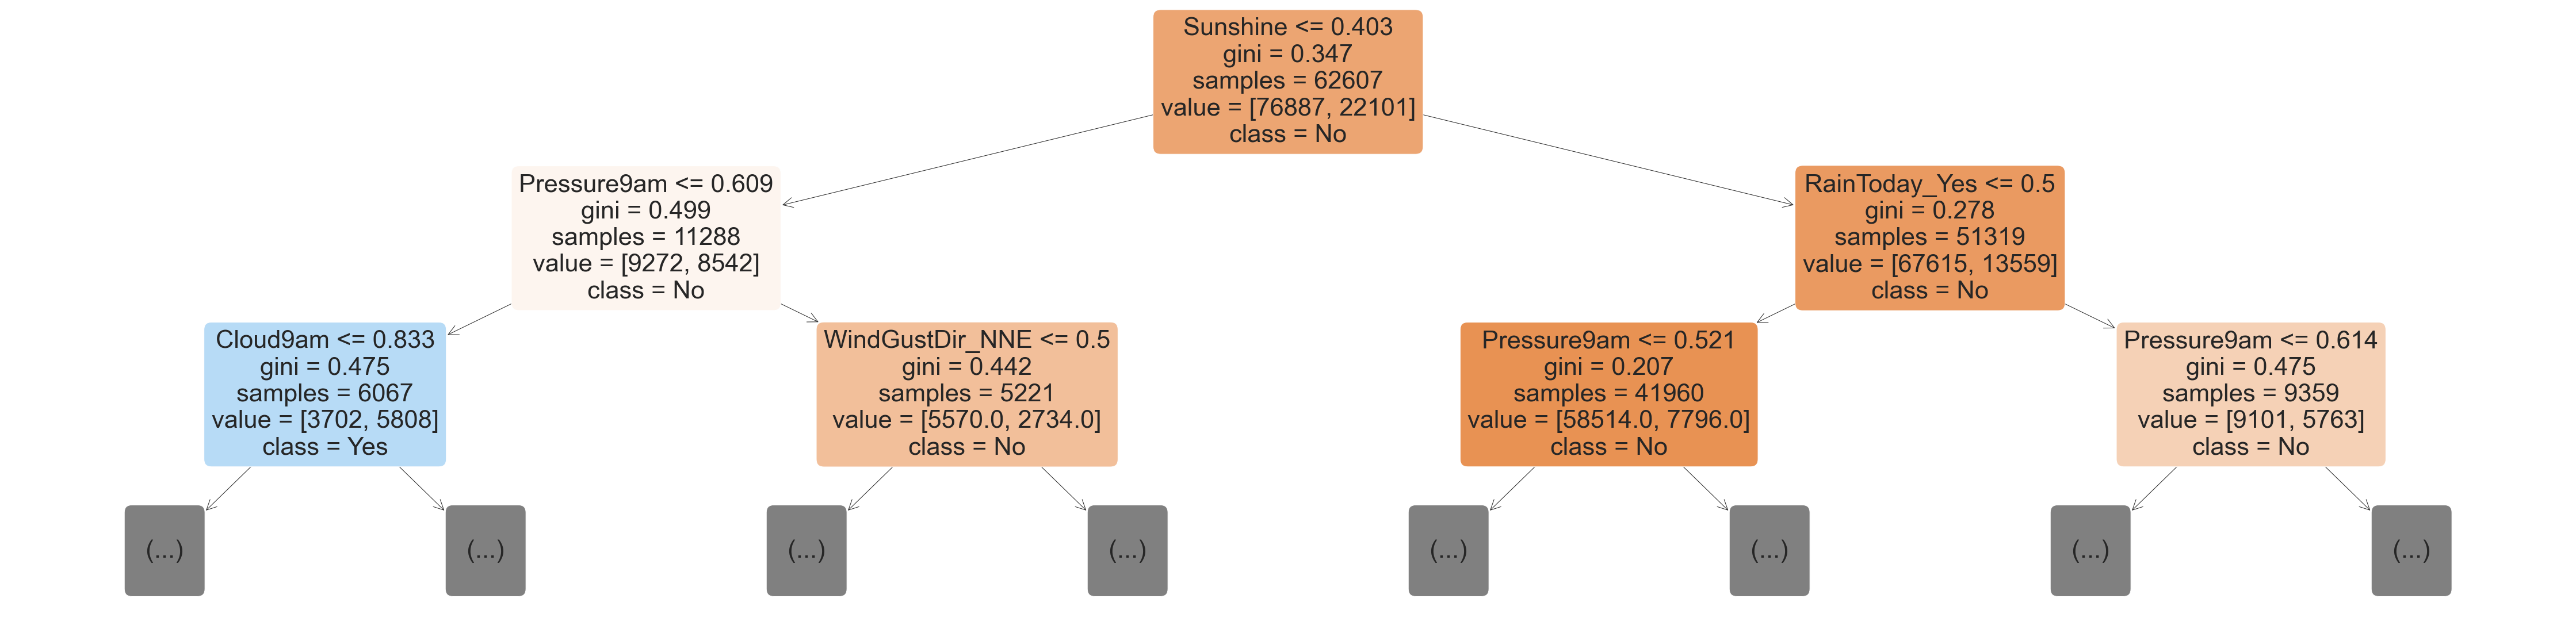

In [131]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=
         model.classes_);

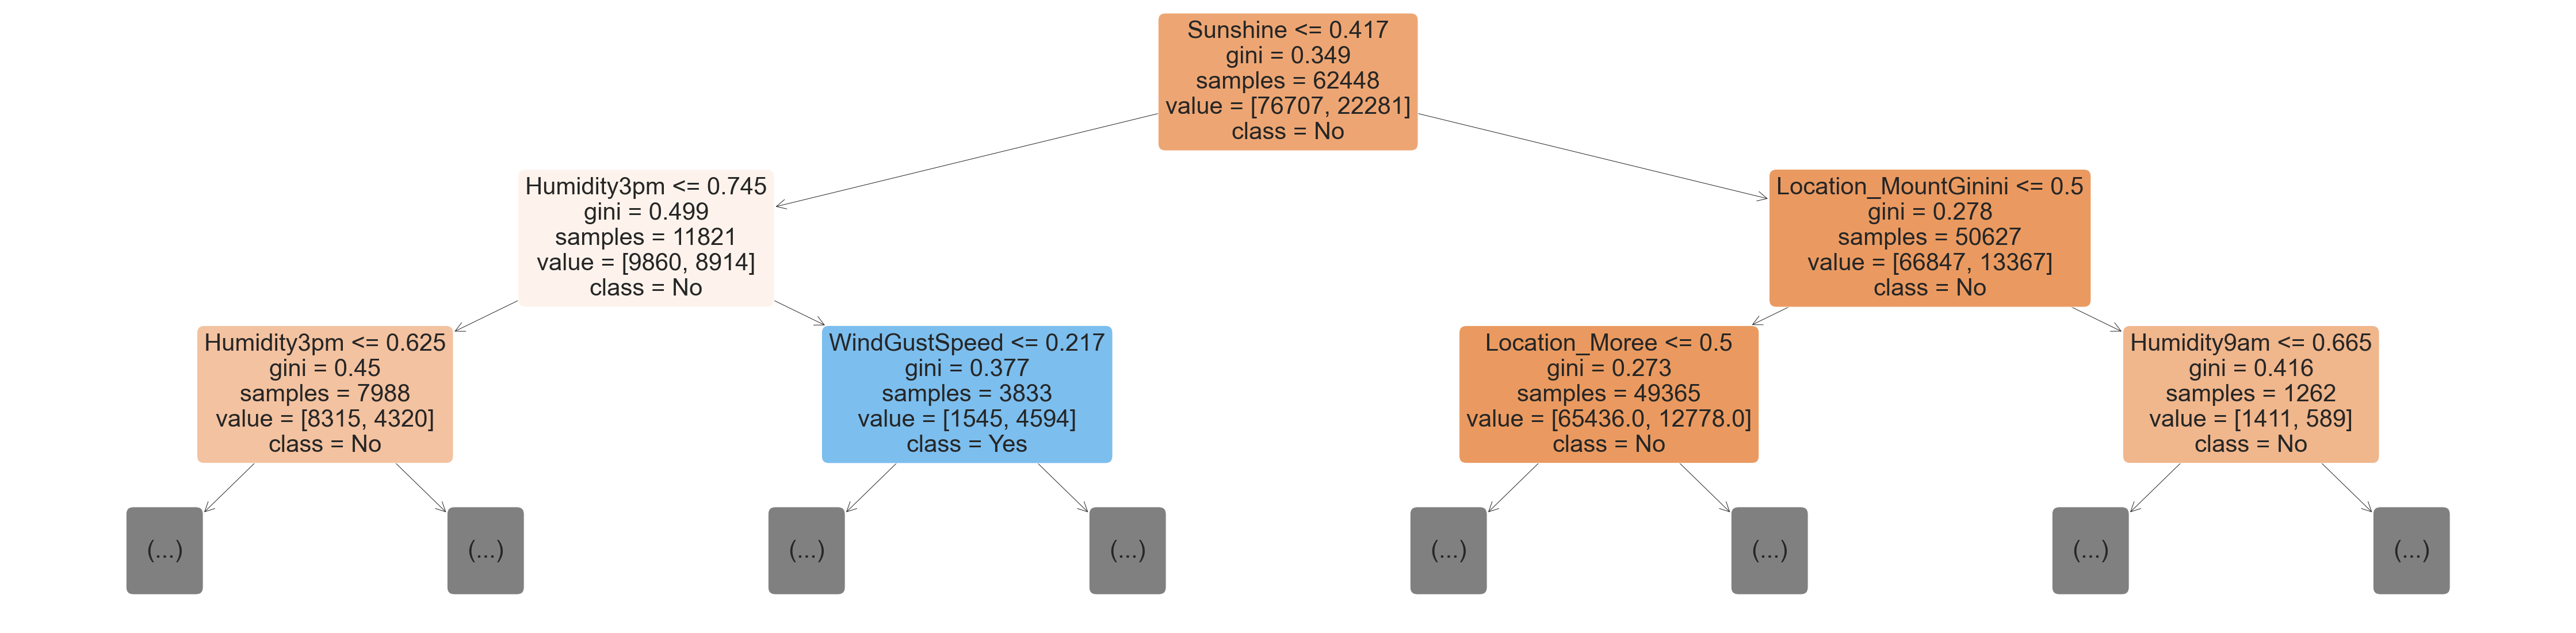

In [132]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[15], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=
         model.classes_);

In [133]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [134]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [136]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/807834351.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(importance_df.head(10), y='feature', x='importance', palette='husl')


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

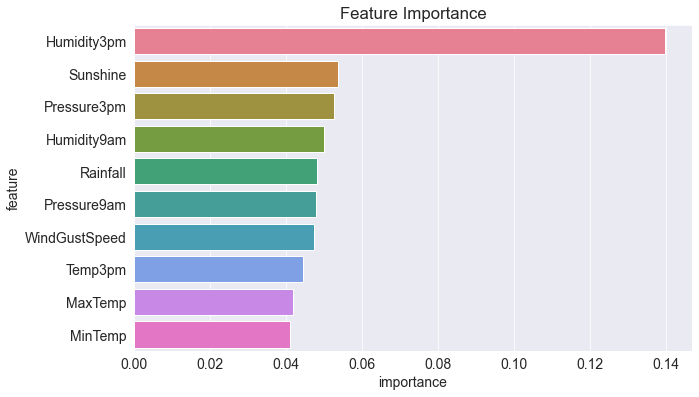

In [139]:
plt.title('Feature Importance')
sns.barplot(importance_df.head(10), y='feature', x='importance', palette='husl')

In statistics and machine learning, "skewness" refers to the degree to which a distribution differs from a symmetrical, bell-shaped curve (like a normal distribution). A skewed distribution is one where the data points are not evenly distributed around the mean, but rather concentrated on one side. A distribution can be positively skewed (tail extends to the right) or negatively skewed (tail extends to the left).

When comparing the distribution of predictions from an ensemble model to that of a single decision tree, the statement suggests that the distribution produced by the ensemble model is less skewed. In other words, the ensemble model tends to produce predictions that are more balanced across different values compared to a single decision tree, which might exhibit more extreme predictions in one direction due to its limitations in capturing the complexity of the data. This reduction in skewness often indicates that the ensemble model is more robust and less prone to overfitting than a single decision tree.

In [140]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's create a base model with which we can compare models with tuned hyperparameters.

In [141]:
base_model = RandomForestClassifier(random_state=42,n_jobs=-1).fit(X_train,train_targets)

In [142]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [143]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999494888269285, 0.8566537055307295)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. Randomness helps reduce overfitting. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [145]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [146]:
model.fit(X_train, train_targets)


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [147]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.986958015112943, 0.8485868492832686)

**100 estimators**

In [151]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100).fit(X_train, train_targets)

In [152]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999494888269285, 0.8566537055307295)

**500 estimators**

In [153]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500).fit(X_train, train_targets)

In [154]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999797955307714, 0.8577563693343393)

Here, we saw that from going from 10 to 100, we achieved 1% better accuracy, and going from 100 to 500, we got 0.1% increase at the cost of more time. Which is not a very suitable. 

**NOTE** One can increase n_estimators to a very large value, because in practice you are only increasing randomness without changing the complexity of the data. In this case, one shouldnt worry about the overfitting of the data too

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

### Helper function below.


we are using **params based onthe python function kwargs

In Python, **kwargs is used to pass a variable number of keyword arguments to a function**. The kwargs parameter stands for "keyword arguments." It allows you to pass key-value pairs as arguments to a function, where the keys are the parameter names and the values are the corresponding arguments.


def example_function(**kwargs):
    for key, value in kwargs.items():
        print(f"Key: {key}, Value: {value}")


example_function(name="John", age=30, city="New York")


In this example, **kwargs allows you to pass any number of keyword arguments to the example_function function. Inside the function, kwargs is treated as a dictionary, allowing you to access the key-value pairs using the .items() method or by directly accessing the keys.



In [155]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [157]:
test_params(max_depth=5)

(0.8197862367155615, 0.8240961058557251)

In [158]:
test_params(max_depth=26)

(0.9814826039519942, 0.8572340549010504)

In [159]:
test_params(max_leaf_nodes=2**5)

(0.8314341132258456, 0.833904010214149)

In [160]:
test_params(max_leaf_nodes=2**20)

(0.9999595910615429, 0.8558992513493123)

In [162]:
base_accs #no max depth or max leaf nodes 

(0.9999494888269285, 0.8566537055307295)

In [163]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split. 

This decorrelates the trees in the ensemble and helps in reducing overfitting. If we dont do this, then basically we are copying of same decison tree, which is just a waste of time.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [166]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan', 'RainToday_No',
       'RainToday_Yes', 'RainToday_nan'],
      dtype='object', length=119)

In [172]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [173]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

In [174]:
test_params(max_features=20)

(0.9999595910615429, 0.8565956705936975)

In [175]:
base_accs

(0.9999494888269285, 0.8566537055307295)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [176]:
test_params(min_samples_split=5, min_samples_leaf=2)

(0.9573584676930537, 0.855144797167895)

In [178]:
test_params(min_samples_split=100, min_samples_leaf=40)

(0.8529316684850689, 0.8464975915501132)

By specifying above arguments of 100 and 40, we are decreasing the power of DT because we are saying that a node cant split if it has less than 100 rows, and it will not split if the leaf has less than 40 rows. The high values of min_samples_split and min_samples_leaf has put us un **underfit situation**

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.

Values should be less than 1 (even 0.1 i would say)


In [182]:
test_params(min_impurity_decrease=0.3)

(0.774891906089627, 0.7882885497069235)

In [180]:
test_params(min_impurity_decrease=1e-2)

(0.774891906089627, 0.7882885497069235)

In [181]:
test_params(min_impurity_decrease=1e-6)

(0.9888168262819735, 0.8561313910974406)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.


BOOTSTRAPPING: 
for eg, we have 10 rows in our datasets, what we do is randomly pick a row and create a "conceptual copy" of it, and forgot that a row has been selected from the dataset, now we do the same for other row, and keep on adding it to the   "conceptual copy"  which will be fed to the model. So, its possible that some rows have picked up multiple times and some rows have not been picked up at all in the  "conceptual copy". Each DT, will be only trained on particular fraction of dataset. 
We are also assigning a "different" weight (of picking) to each rows, as some are picked up multiple time and some not.

In [183]:
test_params(bootstrap=False) # didnt make a difference from the bagging but on a large datasets it does have a big impact

(0.9999797955307714, 0.8567697754047937)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [184]:
test_params(max_samples=0.8)

(0.9989392653654988, 0.855725146538216)

### `class_weight`

In [186]:
train_targets.value_counts()/len(train_targets)

No     0.774892
Yes    0.225108
Name: RainTomorrow, dtype: float64

So, we see we have little number of "Yes". what we would like to do is to give the class Yes a little higher weight

In [187]:
test_params(class_weight={'No':1, 'Yes':2})

(0.9999595910615429, 0.8558412164122802)

In [188]:
test_params(class_weight='balanced')

(0.9999595910615429, 0.8553769369160235)

In the balanced case, scikit will automatically figure out that the classes have different size, and will assing a weight accordingly. For eg. yes is 3 times less than No class, so it will assign a weight of 3 to Yes and 1 to No

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [189]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30, 
                               class_weight={'No': 1, 'Yes': 1.5})

In [190]:
model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [191]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9920192346547057, 0.8563054959085369)

In [192]:
base_accs

(0.9999494888269285, 0.8566537055307295)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting. FOR Eg, logistic regression has a limitation that it will not be able to capture the non-linear relationship properly

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

In [194]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson3" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson3


'https://jovian.com/pragyakiran03041996/lesson3'

## Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [195]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [196]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [197]:
predict_input(model, new_input)


/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/3775630190.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/3775630190.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53070/3775630190.py:5: PerformanceWarning: DataFrame is highly fragmented.  T

('Yes', 0.7608595348304203)

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [198]:
import joblib

In [199]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [200]:
joblib.dump(aussie_rain, 'aussie_rain_RandomForest.joblib')

['aussie_rain_RandomForest.joblib']

In [201]:
aussie_rain2 = joblib.load('aussie_rain_RandomForest.joblib')

The object can be loaded back using `joblib.load` and even if you close the notebook, you can use this joblib file to get the output for the "new inputs". As the aussie_rain_RandomForest already contains the model that has been used to trained on the input_dataset

## Summary and References

The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting & hyperparameter tuning
- Making predictions on single inputs



We also introduced the following terms:

- **Decision Tree**: A hierarchical tree-like structure used for decision-making, where each internal node represents a decision based on a feature, and each leaf node represents an outcome or class label.

- **Random Forest**: A machine learning ensemble method that combines multiple decision trees to make predictions. Each tree in the forest is trained on a random subset of the training data and features, and predictions are aggregated through voting or averaging.

- **Overfitting**: The phenomenon where a machine learning model captures noise or random fluctuations in the training data instead of underlying patterns, resulting in poor performance on unseen data.

- **Hyperparameter**: Parameters of a machine learning algorithm that are set before the training process begins and control aspects such as model complexity, learning rate, or regularization strength.

- **Hyperparameter Tuning**: The process of optimizing the hyperparameters of a machine learning model to improve its performance on unseen data, often through techniques like grid search, random search, or Bayesian optimization.

- **Ensembling**: The technique of combining multiple individual models to create a more powerful model. Ensembling methods include techniques like bagging, boosting, and stacking.

- **Generalization**: The ability of a machine learning model to perform well on unseen data, indicating its ability to capture underlying patterns in the data rather than memorizing the training examples.

- **Bootstrapping**: A statistical resampling technique where multiple datasets are created by sampling with replacement from the original dataset. It is commonly used in methods like bagging to create diverse training sets for ensemble models.

Check out the following resources to learn more: 

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
- https://www.kaggle.com/c/home-credit-default-risk/discussion/64821

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>